In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
import torch
from dotenv import load_dotenv
from hydra import compose
from hydra.core.global_hydra import GlobalHydra
from hydra.initialize import initialize_config_dir
from hydra.utils import instantiate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, LogLocator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import resample

load_dotenv()

plt.style.use("science")

In [ ]:
# Define the relative path to your config directory
config_dir_relative = "../../src/conf"
config_dir_absolute = os.path.join(os.getcwd(), config_dir_relative)
GlobalHydra.instance().clear()

with initialize_config_dir(config_dir=config_dir_absolute, version_base=None):
    cfg = compose(
        config_name="experiment/rgbmnist_Flow/fm_embed",
        overrides=[
            "++seed=42",
            "+paths.embedding_dir=/Users/rogersb/Desktop/wwdc_cs/WhatWeDontCatalog/examples/mnist/embeddings_flowmatch_w_1.0_full/5389300_0/",
            # f"+lightning_loader.ckpt_path={os.environ["MNIST_FLOW_MODEL_CKPT"]}",
        ],
    )
conditional_dataloader = instantiate(cfg.data.embedding_loader)
conditional_dataloader.setup()

with initialize_config_dir(config_dir=config_dir_absolute, version_base=None):
    cfg = compose(
        config_name="experiment/rgbmnist_Flow/fm_embed",
        overrides=[
            "++seed=42",
            "+paths.embedding_dir=/Users/rogersb/Desktop/wwdc_cs/WhatWeDontCatalog/examples/mnist/embeddings_flowmatch_w_0.0_full/5389300_0/",
            # f"+lightning_loader.ckpt_path={os.environ["MNIST_FLOW_MODEL_CKPT"]}",
        ],
    )
unconditional_dataloader = instantiate(cfg.data.embedding_loader)
unconditional_dataloader.setup()

In [ ]:
x_cond_train = []
x_cond_val = []
x_cond_test = []

x_uncond_train = []
x_uncond_val = []
x_uncond_test = []

n_iter = 1

y_vars = {
    "r": {
        "cond_train": [],
        "cond_val": [],
        "cond_test": [],
        "uncond_train": [],
        "uncond_val": [],
        "uncond_test": [],
        "cond_train_scores": [[] for _ in range(n_iter)],
        "cond_val_scores": [[] for _ in range(n_iter)],
        "cond_test_scores": [[] for _ in range(n_iter)],
        "uncond_train_scores": [[] for _ in range(n_iter)],
        "uncond_val_scores": [[] for _ in range(n_iter)],
        "uncond_test_scores": [[] for _ in range(n_iter)],
    },
    "b": {
        "cond_train": [],
        "cond_val": [],
        "cond_test": [],
        "uncond_train": [],
        "uncond_val": [],
        "uncond_test": [],
        "cond_train_scores": [[] for _ in range(n_iter)],
        "cond_val_scores": [[] for _ in range(n_iter)],
        "cond_test_scores": [[] for _ in range(n_iter)],
        "uncond_train_scores": [[] for _ in range(n_iter)],
        "uncond_val_scores": [[] for _ in range(n_iter)],
        "uncond_test_scores": [[] for _ in range(n_iter)],
    },
    "g": {
        "cond_train": [],
        "cond_val": [],
        "cond_test": [],
        "uncond_train": [],
        "uncond_val": [],
        "uncond_test": [],
        "cond_train_scores": [[] for _ in range(n_iter)],
        "cond_val_scores": [[] for _ in range(n_iter)],
        "cond_test_scores": [[] for _ in range(n_iter)],
        "uncond_train_scores": [[] for _ in range(n_iter)],
        "uncond_val_scores": [[] for _ in range(n_iter)],
        "uncond_test_scores": [[] for _ in range(n_iter)],
    },
    "digit": {
        "cond_train": [],
        "cond_val": [],
        "cond_test": [],
        "uncond_train": [],
        "uncond_val": [],
        "uncond_test": [],
        "cond_train_scores": [[] for _ in range(n_iter)],
        "cond_val_scores": [[] for _ in range(n_iter)],
        "cond_test_scores": [[] for _ in range(n_iter)],
        "uncond_train_scores": [[] for _ in range(n_iter)],
        "uncond_val_scores": [[] for _ in range(n_iter)],
        "uncond_test_scores": [[] for _ in range(n_iter)],
    },
}

for cond_train, uncond_train in zip`(
    conditional_dataloader.train_dataloader(),
    unconditional_dataloader.train_dataloader(),
    strict=False,
):
    x_cond_train.append(cond_train["ode_trajectory"].permute(1, 0, 2))
    x_uncond_train.append(uncond_train["ode_trajectory"].permute(1, 0, 2))

    for label in ["r", "g", "b", "digit"]:
        y_vars[label]["cond_train"].append(cond_train[label])
        y_vars[label]["uncond_train"].append(uncond_train[label])


for cond_val, uncond_val in zip(
    conditional_dataloader.val_dataloader(),
    unconditional_dataloader.val_dataloader(),
    strict=False,
):
    x_cond_val.append(cond_val["ode_trajectory"].permute(1, 0, 2))
    x_uncond_val.append(uncond_val["ode_trajectory"].permute(1, 0, 2))
    for label in ["r", "g", "b", "digit"]:
        y_vars[label]["cond_val"].append(cond_val[label])
        y_vars[label]["uncond_val"].append(uncond_val[label])


for cond_test, uncond_test in zip(
    conditional_dataloader.test_dataloader(),
    unconditional_dataloader.test_dataloader(),
    strict=False,
):
    x_cond_test.append(cond_test["ode_trajectory"].permute(1, 0, 2))
    x_uncond_test.append(uncond_test["ode_trajectory"].permute(1, 0, 2))
    for label in ["r", "g", "b", "digit"]:
        y_vars[label]["cond_test"].append(cond_test[label])
        y_vars[label]["uncond_test"].append(uncond_test[label])

x_cond_train = torch.cat(x_cond_train, dim=1)
x_cond_val = torch.cat(x_cond_val, dim=1)
x_cond_test = torch.cat(x_cond_test, dim=1)
x_uncond_train = torch.cat(x_uncond_train, dim=1)
x_uncond_val = torch.cat(x_uncond_val, dim=1)
x_uncond_test = torch.cat(x_uncond_test, dim=1)

for label in ["r", "g", "b", "digit"]:
    y_vars[label]["cond_train"] = torch.cat(y_vars[label]["cond_train"], dim=0)
    y_vars[label]["cond_val"] = torch.cat(y_vars[label]["cond_val"], dim=0)
    y_vars[label]["cond_test"] = torch.cat(y_vars[label]["cond_test"], dim=0)

    y_vars[label]["uncond_train"] = torch.cat(y_vars[label]["uncond_train"], dim=0)
    y_vars[label]["uncond_val"] = torch.cat(y_vars[label]["uncond_val"], dim=0)
    y_vars[label]["uncond_test"] = torch.cat(y_vars[label]["uncond_test"], dim=0)

Python(1248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1258) MallocStackLoggin

In [130]:
i = 0
for label in ["r", "g", "b"]:
    for t in range(len(x_cond_train)):
        clf = LinearRegression()
        clf.fit(x_cond_train[t], y_vars[label]["cond_train"].squeeze(1))
        y_vars[label]["cond_test_scores"][i].append(
            clf.score(x_cond_test[t], y_vars[label]["cond_test"])
        )
        y_vars[label]["cond_val_scores"][i].append(
            clf.score(x_cond_val[t], y_vars[label]["cond_val"])
        )
        y_vars[label]["cond_train_scores"][i].append(
            clf.score(x_cond_train[t], y_vars[label]["cond_train"])
        )

'for label in ["r", "g", "b"]:\n    for t in range(len(x_uncond_train)):\n        clf = LinearRegression()\n        clf.fit(\n            x_uncond_train[t], \n            y_vars[label]["uncond_train"].squeeze(1)\n        )\n        y_vars[label]["uncond_test_scores"][i].append(\n            clf.score(\n                x_uncond_test[t], \n                y_vars[label]["uncond_test"]\n            )\n        )\n        y_vars[label]["cond_val_scores"][i].append(\n            clf.score(\n                x_uncond_val[t], \n                y_vars[label]["uncond_val"]\n            )\n        )\n        y_vars[label]["uncond_train_scores"][i].append(\n            clf.score(\n                x_uncond_train[t], \n                y_vars[label]["uncond_train"]\n            )\n        )'

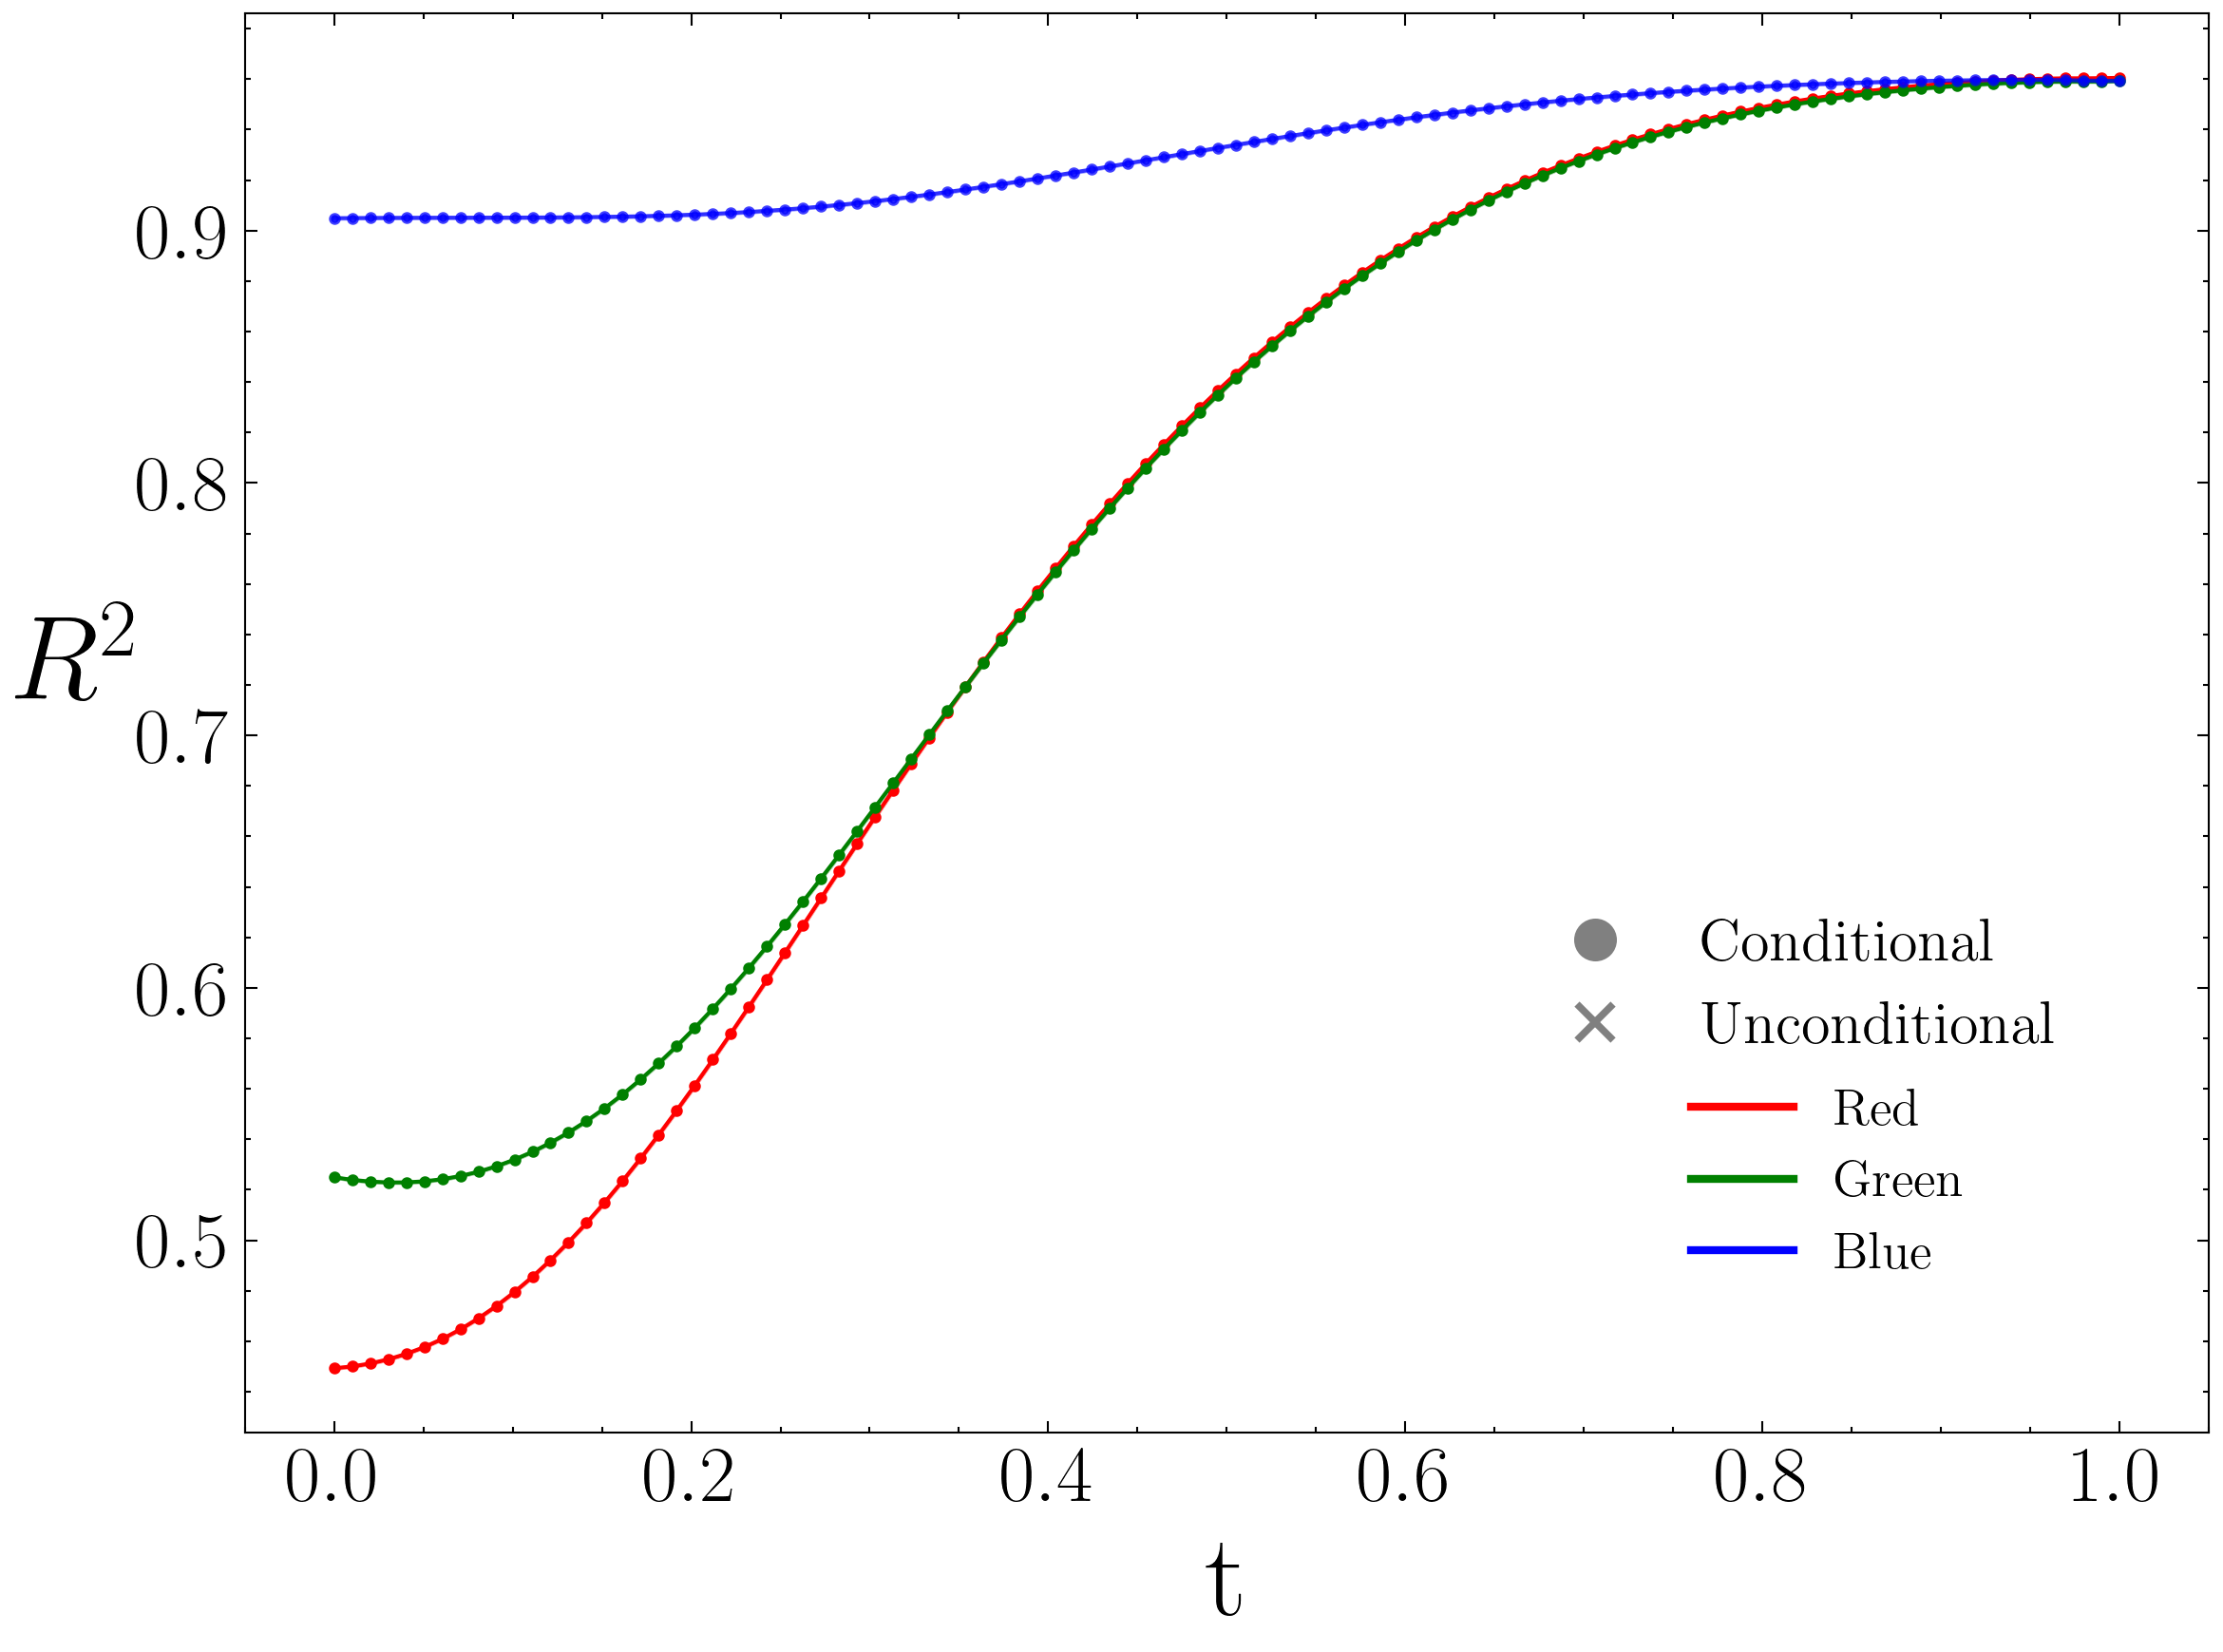

In [131]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# --- Loop 1: Conditional scores for 'r' and 'g' ---
for label in ["r", "g"]:
    scores = np.stack(y_vars[label]["cond_test_scores"])
    mean = scores.mean(axis=0)
    std = scores.std(axis=0)
    x_vals = torch.linspace(1, 0, 100)

    # Plot the mean line
    ax.plot(
        x_vals,
        mean,
        label=f"{label}" + r" Conditional",
        c=label,
        marker="o",
        markersize=2,
    )
    # Add the shaded confidence interval
    ax.fill_between(
        x_vals,
        mean - std,
        mean + std,
        color=label,
        alpha=0.25,  # Use alpha to make the shading semi-transparent
    )

# --- Loop 2: Conditional scores for 'b' ---
for label in ["b"]:
    scores = np.stack(y_vars[label]["cond_test_scores"])
    mean = scores.mean(axis=0)
    std = scores.std(axis=0)
    x_vals = torch.linspace(1, 0, 100)

    # Plot the mean line
    ax.plot(
        x_vals,
        mean,
        label=f"{label}" + r" Conditionaly",
        c=label,
        alpha=0.75,
        markersize=2,
        marker="o",
    )
    # Add the shaded confidence interval
    ax.fill_between(x_vals, mean - std, mean + std, color=label, alpha=0.25)

"""# --- Loop 3: Unconditional scores ---
for label in [
    "r",
    "g",
    "b",
]:
    scores = np.stack(y_vars[label]["uncond_test_scores"])
    mean = scores.mean(axis=0)
    std = scores.std(axis=0)
    x_vals = torch.linspace(1, 0, 100)

    # Plot the mean line
    ax.plot(
        x_vals,
        mean,
        label="Unconditional",
        c=label,
        ls="--",
        alpha=0.25,
        marker="x",
    )
    # Add the shaded confidence interval
    ax.fill_between(x_vals, mean - std, mean + std, color=label, alpha=0.25)"""

style_handles = [
    Line2D(
        [0],
        [0],
        linestyle="None",
        marker="o",  # circle
        markersize=9,
        markeredgecolor="gray",
        markerfacecolor="gray",
        markeredgewidth=1.8,
        label="Conditional",
    ),
    Line2D(
        [0],
        [0],
        linestyle="None",
        marker="x",  # cross
        markersize=9,
        markeredgecolor="gray",
        markerfacecolor="gray",
        markeredgewidth=1.8,
        label="Unconditional",
    ),
]

style_handles = ax.legend(
    handles=style_handles, bbox_to_anchor=(0.95, 0.4), fontsize=15
)

ax.add_artist(style_handles)

rgb_handles = [
    Line2D([0], [0], color="red", linestyle="-", linewidth=2, label="Red"),
    Line2D([0], [0], color="green", linestyle="-", linewidth=2, label="Green"),
    Line2D([0], [0], color="blue", linestyle="-", linewidth=2, label="Blue"),
]

ax.legend(
    handles=rgb_handles,
    loc="upper right",  # choose where you want this one
    bbox_to_anchor=(0.9, 0.275),  # tweak as needed
    fontsize=13,
    title_fontsize=12,
)

# --- Final plot adjustments ---
ax.tick_params(axis="both", which="major", labelsize=20)
ax.set_ylabel(r"$R^2$", fontsize=30, loc="center", rotation=0, labelpad=15)
ax.set_xlabel("t", fontsize=30)

fig.tight_layout()
# fig.savefig("./r2.pdf")

### Label efficiency

In [194]:
num_examples = torch.logspace(base=2, start=7, end=15, steps=17, dtype=int)
num_examples = torch.cat([num_examples, torch.tensor([48000])])
print(num_examples)

tensor([  128,   181,   256,   362,   512,   724,  1024,  1448,  2048,  2896,
         4096,  5792,  8192, 11585, 16384, 23170, 32768, 48000])


In [356]:
n_iter = 3

scores = {
    "r": [[] for _ in range(3)],
    "g": [[] for _ in range(3)],
    "b": [[] for _ in range(3)],
}

for label in ["r", "g", "b"]:
    for n in num_examples:
        for i in range(n_iter):
            clf = LinearRegression()
            X_train, y_train = resample(
                x_cond_train[-1],
                y_vars[label]["cond_train"].squeeze(1),
                n_samples=int(n),
                random_state=i,
            )

            clf.fit(X_train, y_train)
            scores[label][i].append(
                clf.score(x_cond_test[t], y_vars[label]["cond_test"])
            )

for label in ["r", "g", "b"]:
    scores[label] = np.stack(scores[label])

In [358]:
n_iter = 3

scores_uncond = {
    "r": [[] for _ in range(3)],
    "g": [[] for _ in range(3)],
    "b": [[] for _ in range(3)],
}

for label in ["r", "g", "b"]:
    for n in num_examples:
        for i in range(n_iter):
            clf = LinearRegression()
            X_train, y_train = resample(
                x_uncond_train[-1],
                y_vars[label]["uncond_train"].squeeze(1),
                n_samples=int(n),
                random_state=i,
            )

            clf.fit(X_train, y_train)
            scores_uncond[label][i].append(
                clf.score(x_uncond_test[t], y_vars[label]["uncond_test"])
            )

for label in ["r", "g", "b"]:
    scores_uncond[label] = np.stack(scores_uncond[label])

scores_vae = {
    "r": [[] for _ in range(3)],
    "g": [[] for _ in range(3)],
    "b": [[] for _ in range(3)],
}

for label in ["r", "g", "b"]:
    for n in num_examples:
        for i in range(n_iter):
            clf = LinearRegression()
            X_train, y_train = resample(
                x_cond_train[0],
                y_vars[label]["cond_train"].squeeze(1),
                n_samples=int(n),
                random_state=i,
            )

            clf.fit(X_train, y_train)
            scores_vae[label][i].append(
                clf.score(x_cond_test[0], y_vars[label]["cond_test"])
            )

for label in ["r", "g", "b"]:
    scores_vae[label] = np.stack(scores_vae[label])

Python(38253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


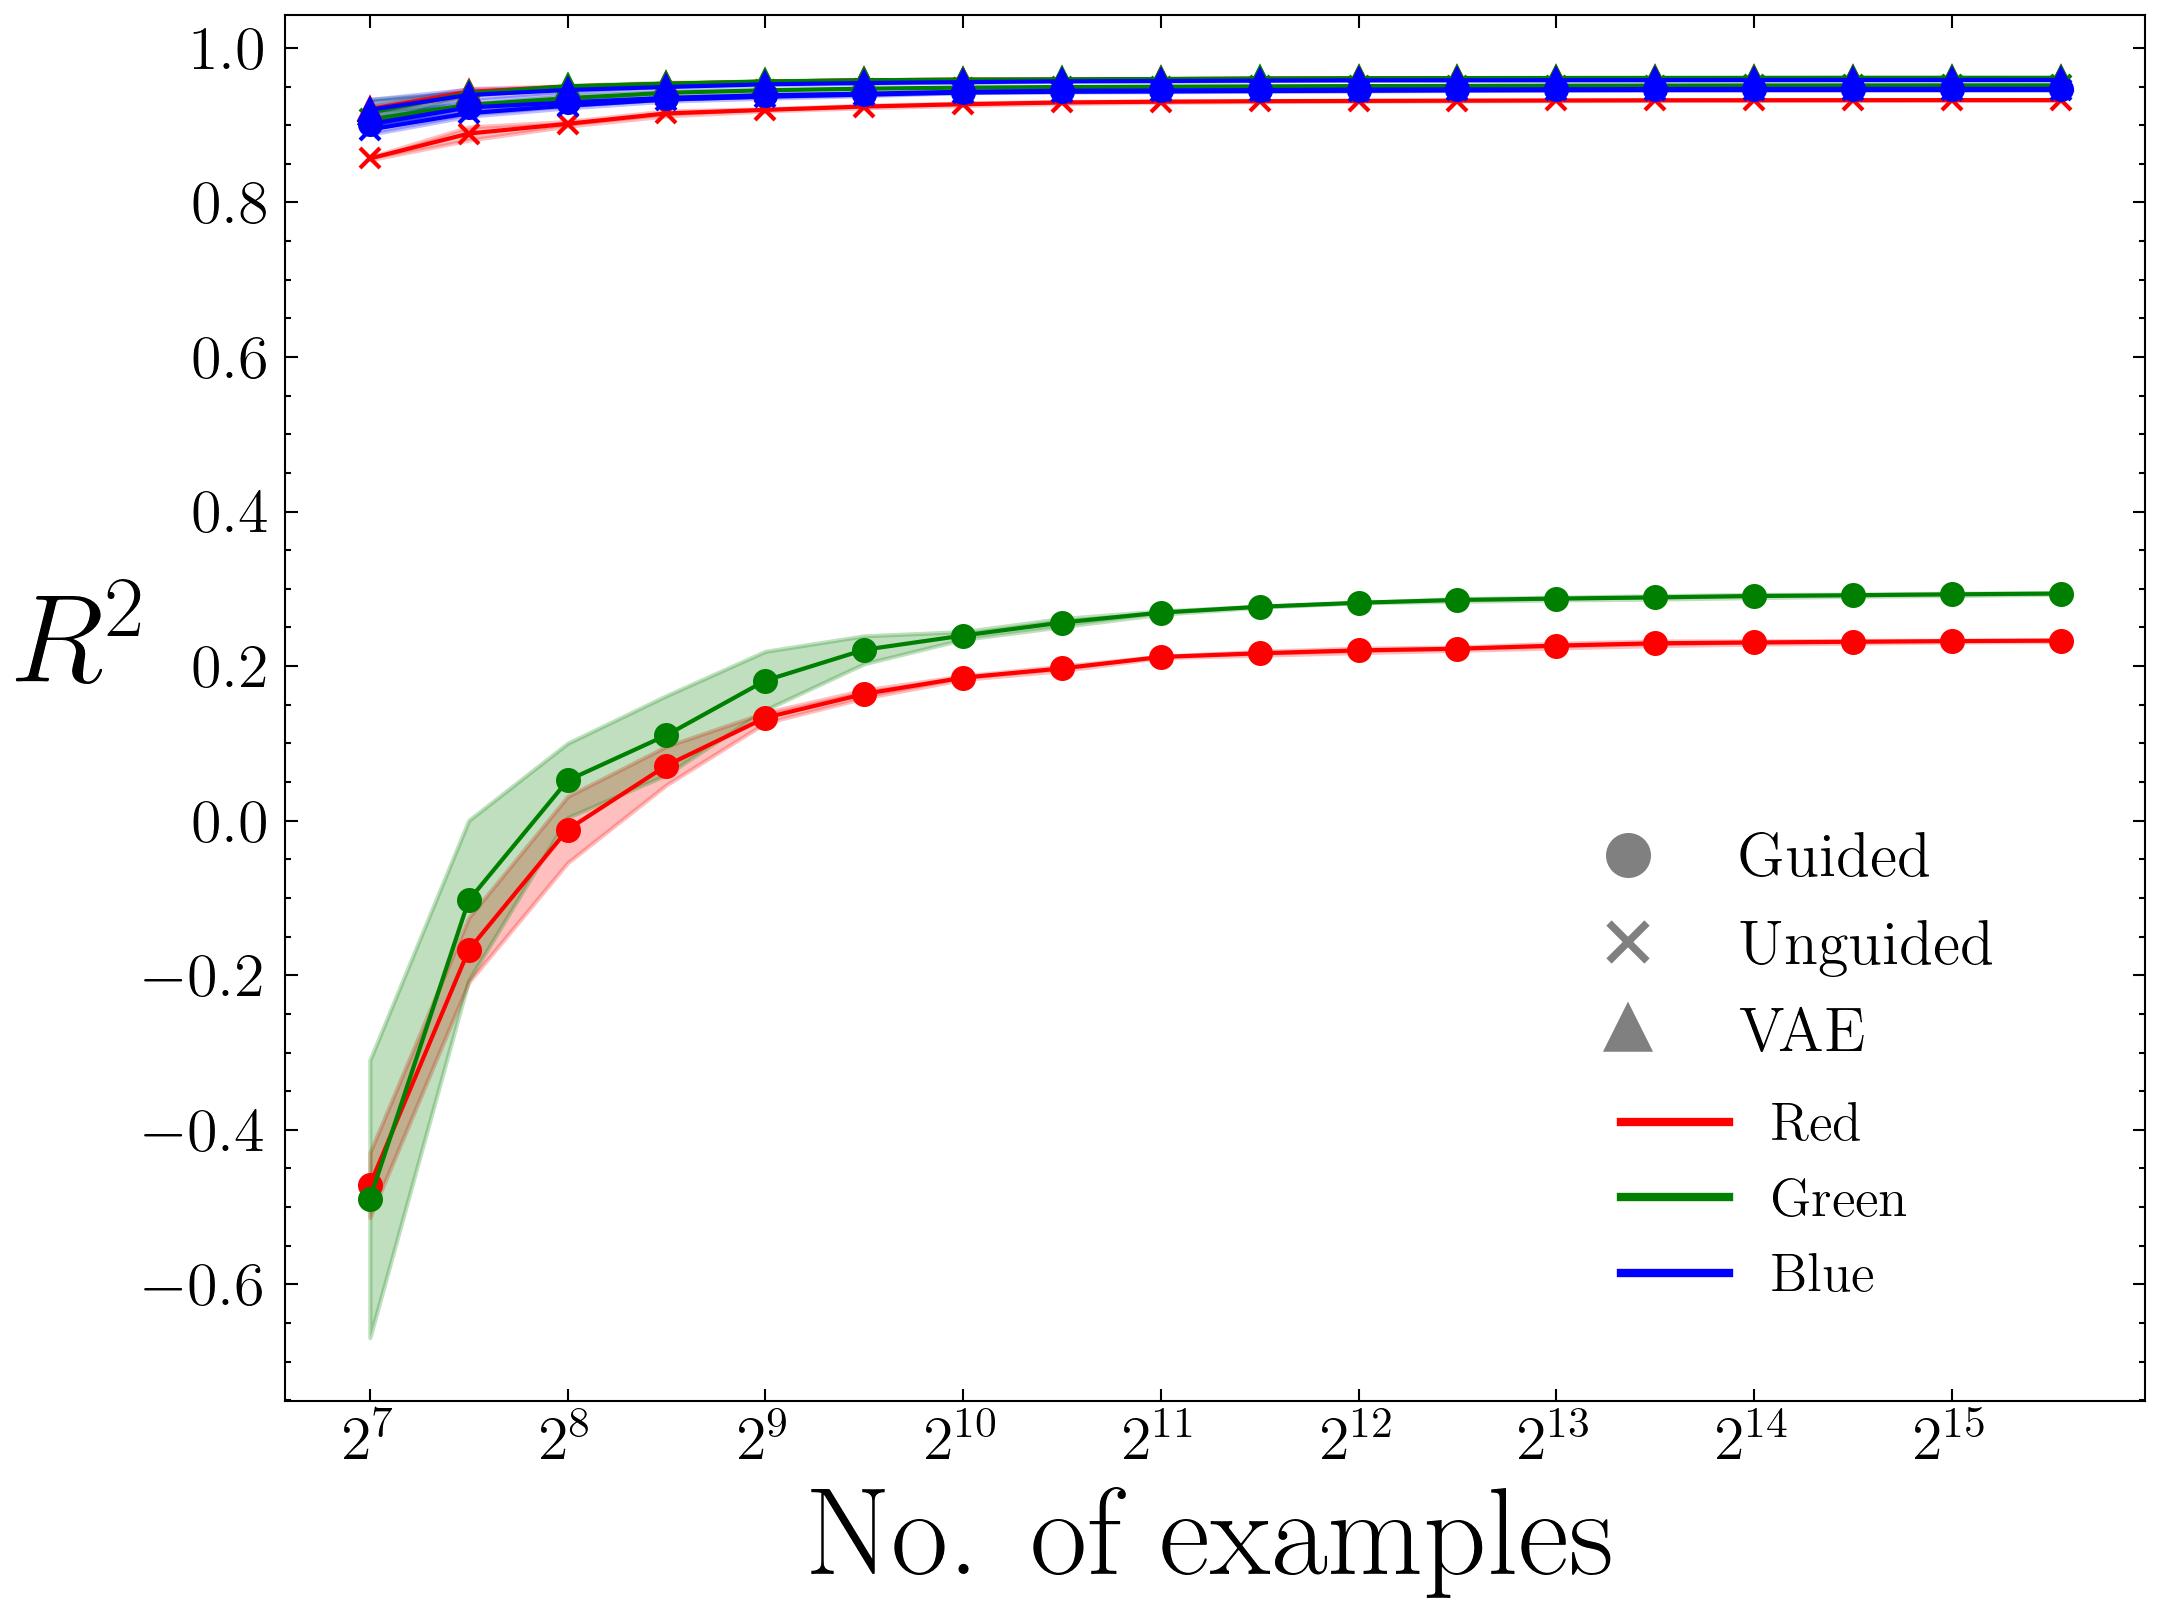

In [367]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

for label in ["r", "g"]:
    mean = scores[label].mean(axis=0)
    std = scores[label].std(axis=0)

    ax.plot(
        num_examples,
        scores[label].mean(axis=0),
        c=label,
        marker="o",
        markersize=5,
    )
    ax.fill_between(num_examples, mean - std, mean + std, color=label, alpha=0.25)

for label in ["r", "g", "b"]:
    mean = scores_uncond[label].mean(axis=0)
    std = scores_uncond[label].std(axis=0)

    ax.plot(
        num_examples,
        scores_uncond[label].mean(axis=0),
        c=label,
        marker="x",
        markersize=5,
    )
    ax.fill_between(num_examples, mean - std, mean + std, color=label, alpha=0.25)

for label in ["r", "g", "b"]:
    mean = scores_vae[label].mean(axis=0)
    std = scores_vae[label].std(axis=0)

    ax.plot(
        num_examples,
        mean,
        c=label,
        marker="^",
        markersize=5,
    )
    ax.fill_between(num_examples, mean - std, mean + std, color=label, alpha=0.25)

# Plot conditional on-top
for label in ["b"]:
    mean = scores[label].mean(axis=0)
    std = scores[label].std(axis=0)

    ax.plot(
        num_examples,
        scores[label].mean(axis=0),
        c=label,
        marker="o",
        markersize=5,
    )
    ax.fill_between(num_examples, mean - std, mean + std, color=label, alpha=0.25)

ax.set_xscale("log", base=2)
plt.ylabel(r"$R^2$", fontsize=30, loc="center", rotation=0, labelpad=15)
plt.xlabel("No. of examples", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=15)

style_handles = [
    Line2D(
        [0],
        [0],
        linestyle="None",
        marker="o",  # circle
        markersize=9,
        markeredgecolor="gray",
        markerfacecolor="gray",
        markeredgewidth=1.8,
        label="Guided",
    ),
    Line2D(
        [0],
        [0],
        linestyle="None",
        marker="x",  # cross
        markersize=9,
        markeredgecolor="gray",
        markerfacecolor="gray",
        markeredgewidth=1.8,
        label="Unguided",
    ),
    Line2D(
        [0],
        [0],
        linestyle="None",
        marker="^",  # cross
        markersize=9,
        markeredgecolor="gray",
        markerfacecolor="gray",
        markeredgewidth=1.8,
        label="VAE",
    ),
]

style_handles = ax.legend(
    handles=style_handles, bbox_to_anchor=(0.95, 0.45), fontsize=15
)

ax.add_artist(style_handles)

rgb_handles = [
    Line2D([0], [0], color="red", linestyle="-", linewidth=2, label="Red"),
    Line2D([0], [0], color="green", linestyle="-", linewidth=2, label="Green"),
    Line2D([0], [0], color="blue", linestyle="-", linewidth=2, label="Blue"),
]

ax.legend(
    handles=rgb_handles,
    loc="upper right",  # choose where you want this one
    bbox_to_anchor=(0.9, 0.25),  # tweak as needed
    fontsize=13,
    title_fontsize=12,
)
plt.savefig("./r2_num_examples.pdf")

In [132]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier

label = "digit"
num_iter = 10
f1s_cond = []
f1s_uncond = []

for t in range(len(x_cond_train)):
    clf = OneVsRestClassifier(LogisticRegression(max_iter=500))
    clf.fit(x_cond_train[t], y_vars[label]["cond_train"].squeeze(1))

    y_pred = clf.predict(x_cond_test[t])
    _, _, f1, _ = precision_recall_fscore_support(
        y_vars[label]["cond_test"].squeeze(1), y_pred, average=None
    )

    f1s_cond.append(f1)

    clf = OneVsRestClassifier(LogisticRegression(max_iter=500))
    clf.fit(x_uncond_train[t], y_vars[label]["uncond_train"].squeeze(1))

    y_pred = clf.predict(x_uncond_test[t])
    _, _, f1, _ = precision_recall_fscore_support(
        y_vars[label]["uncond_test"].squeeze(1), y_pred, average=None
    )

    f1s_uncond.append(f1)

# f1s = np.stack(f1s)

In [275]:
label = "digit"
num_iter = 3
f1s_cond = [[] for _ in range(n_iter)]
f1s_uncond = [[] for _ in range(n_iter)]
f1s_vae = [[] for _ in range(n_iter)]


for n in num_examples:
    for i in range(num_iter):
        clf = OneVsRestClassifier(LogisticRegression(max_iter=500))
        X_train, y_train = resample(
            x_cond_train[-1],
            y_vars[label]["cond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(x_cond_test[t])
        _, _, f1, _ = precision_recall_fscore_support(
            y_vars[label]["cond_test"].squeeze(1), y_pred, average=None
        )

        f1s_cond[i].append(f1)

        # -- Uncond -- #
        clf = OneVsRestClassifier(LogisticRegression(max_iter=500))
        X_train, y_train = resample(
            x_uncond_train[-1],
            y_vars[label]["uncond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(x_uncond_test[-1])
        _, _, f1, _ = precision_recall_fscore_support(
            y_vars[label]["uncond_test"].squeeze(1), y_pred, average=None
        )

        f1s_uncond[i].append(f1)

        # -- VAE -- #
        clf = OneVsRestClassifier(LogisticRegression(max_iter=500))
        X_train, y_train = resample(
            x_cond_train[0],
            y_vars[label]["cond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(x_cond_test[0])
        _, _, f1, _ = precision_recall_fscore_support(
            y_vars[label]["cond_test"].squeeze(1), y_pred, average=None
        )

        f1s_vae[i].append(f1)

f1s_cond = np.stack(f1s_cond)
f1s_uncond = np.stack(f1s_uncond)
f1s_vae = np.stack(f1s_vae)

In [340]:
label = "digit"
num_iter = 3
accs_cond = [[] for _ in range(n_iter)]
accs_uncond = [[] for _ in range(n_iter)]
accs_vae = [[] for _ in range(n_iter)]


for n in num_examples:
    for i in range(num_iter):
        clf = LogisticRegression(max_iter=500)

        X_train, y_train = resample(
            x_cond_train[-1],
            y_vars[label]["cond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        accs_cond[i].append(
            clf.score(x_cond_test[t], y_vars[label]["cond_test"].squeeze(1))
        )

        # -- Uncond -- #
        clf = LogisticRegression(max_iter=500)

        X_train, y_train = resample(
            x_uncond_train[-1],
            y_vars[label]["uncond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        accs_uncond[i].append(
            clf.score(x_uncond_test[t], y_vars[label]["uncond_test"].squeeze(1))
        )

        # -- VAE -- #
        clf = LogisticRegression(max_iter=500)

        X_train, y_train = resample(
            x_cond_train[0],
            y_vars[label]["cond_train"].squeeze(1),
            n_samples=int(n),
            random_state=i,
        )

        clf.fit(X_train, y_train)

        accs_vae[i].append(
            clf.score(x_cond_test[0], y_vars[label]["cond_test"].squeeze(1))
        )

accs_cond = np.stack(accs_cond)
accs_uncond = np.stack(accs_uncond)
accs_vae = np.stack(accs_vae)

/var/folders/hv/zwl2_8896870n46jsw6xybt80000gp/T/ipykernel_90717/1994199369.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(classes)).colors[:3]
Python(38224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


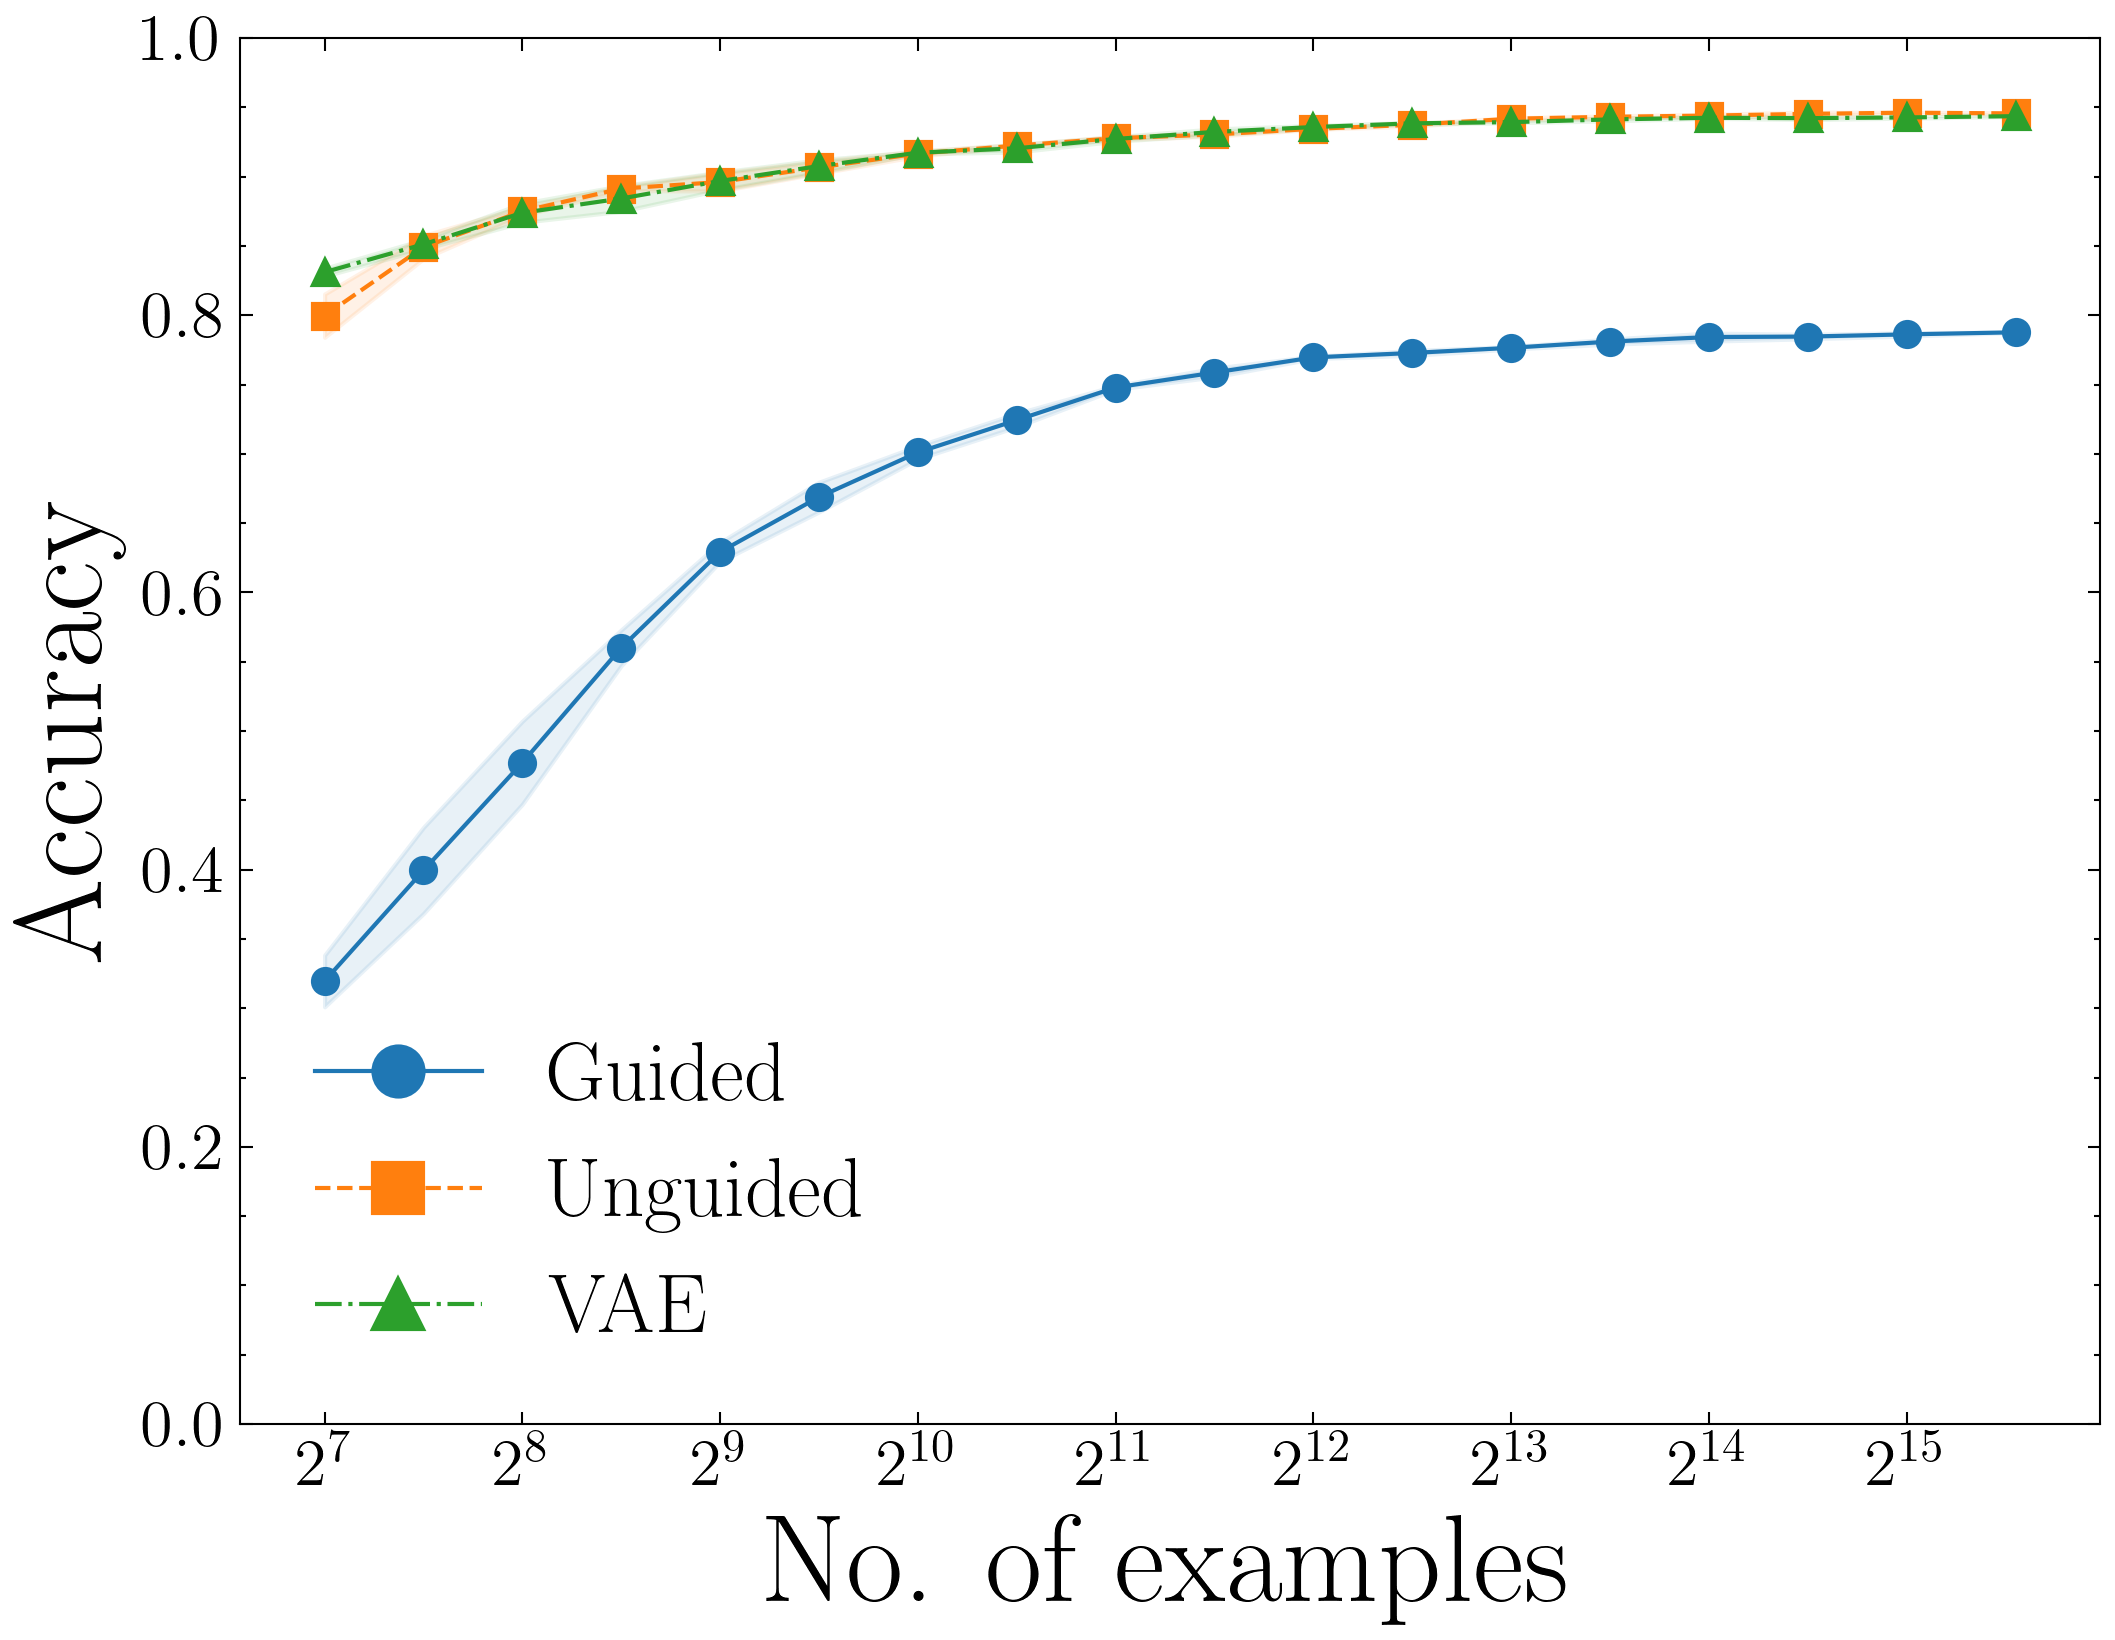

In [366]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

mean = accs_cond.mean(axis=0)
std = accs_cond.std(axis=0)

classes = np.unique(y_vars["digit"]["cond_train"].numpy())

# 2. Define distinct colors and markers
# 'tab10' is a great colormap for 10 distinct categories
colors = plt.cm.get_cmap("tab10", len(classes)).colors[:3]
markers = ["o", "s", "^"]  # , "v", "D", "P", "*", "X", "+", "h"]

components = []
# for digit in range(10):
c = colors[0]
"""v = ax.scatter(
    num_examples,
    mean,
    #marker=markers[digit],
    s=10,
    label=f"Condtional",
    c=c,
)"""
ax.plot(num_examples, mean, lw=1, c=c, marker=markers[0], label="Guided")
ax.fill_between(num_examples, mean - std, mean + std, color=c, alpha=0.1)

c = colors[1]
uncond_mean = accs_uncond.mean(axis=0)
uncond_std = accs_uncond.std(axis=0)

ax.plot(
    num_examples,
    uncond_mean,
    lw=1,
    ls="--",
    color=c,
    marker=markers[1],
    label="Unguided",
)
ax.fill_between(
    num_examples, uncond_mean - uncond_std, uncond_mean + uncond_std, color=c, alpha=0.1
)

vae_mean = accs_vae.mean(axis=0)
vae_std = accs_vae.std(axis=0)
c = colors[2]

ax.plot(num_examples, vae_mean, lw=1, ls="-.", color=c, marker=markers[2], label="VAE")
ax.fill_between(
    num_examples, vae_mean - vae_std, vae_mean + vae_std, color=c, alpha=0.1
)

ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_ylabel("Accuracy", fontsize=30)
ax.set_xlabel("No. of examples", fontsize=30)
ax.set_xscale("log", base=2)

plt.legend(fontsize=20, markerscale=2)
plt.ylim(0, 1.0)
plt.savefig("./multiclass_accuracy.pdf")